<a href="https://colab.research.google.com/github/mohitagr18/multimodal_style_coach/blob/main/Style_Coach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. High-Level Introduction

This notebook demonstrates the construction of a **Multimodal, Multi-Agent Style Coach**, an advanced AI application designed to provide personalized fashion recommendations. Built using Google's Agent Development Kit (ADK) and powered by Gemini models, this system goes beyond simple item lookups.

It leverages a team of specialized AI agents that work in concert, implementing an **agentic RAG (Retrieval-Augmented Generation)** pattern to:
* Understand complex, conversational user queries.
* Analyze user-provided images of items using VLM capabilities of `gemini-2.5-flash` to understand the type, style and color of the object.
* Automatically infer user demographics like age and gender to tailor suggestions.
* Conduct real-time trend research using Google Search.
* Perform sophisticated vector searches on a product database, informed by the VLM's image analysis.
* Assemble complete, styled outfits with detailed reasoning explaining why the pieces work together.

This project serves as an advanced example of how to orchestrate multiple agents, handle multimodal inputs, and integrate external tools to create a sophisticated, user-centric application.

## 2. System Architecture: The Multi-Agent Team

The power of the Style Coach lies in its multi-agent architecture. Instead of a single monolithic model, the system uses a team of five specialized AI agents, each with a distinct role, managed by a primary "Coach" agent.

| **Agent** | **Description** |
| :--- | :--- |
| **Style Coach Agent** | The main, user-facing agent that orchestrates the entire process and manages the conversation. It acts as the team manager. |
| **User Profile Agent** | A new agent that analyzes the user's query to infer demographics (age and gender) to provide more personalized styling. |
| **Input Analysis Agent** | A specialized agent whose sole job is to interpret and deconstruct image inputs, extracting key features like item type, style, and color. |
| **Trend Research Agent** | This agent uses Google Search to gather real-world context on fashion trends, aesthetics, and event-specific attire based on user demographics. |
| **Mercari Search Agent**| A dedicated worker agent, implemented as `item_search_tool`, responsible for crafting and executing sophisticated vector searches on the product database based on the research. |
| **Styling & Reasoning Agent** | The final creative expert that assembles the retrieved items into complete, styled outfits and explains *why* they work together, embodying the "coach" role. |

---
### Full Workflow Example

To understand how these agents collaborate, consider a scenario where a user uploads a photo of a vintage leather jacket and asks: *"I just thrifted this jacket. Can you help me style an outfit around it for a rock concert this fall?"*.

1.  **Step 1: The Manager (Style Coach Agent)** receives the image and text. It recognizes the complex request and begins delegating tasks.

2.  **Step 2: The Specialist (Input Analysis Agent)** is given the image. It analyzes it and returns a structured description: `{ "item": "leather jacket", "style": "vintage, bomber", "color": "dark brown" }`.

3.  **Step 3: The Consultant (Trend Research Agent)** is given the query "rock concert this fall." It uses Google Search to find current trends and returns a summary: *"Fall concert style blends 90s grunge and classic rock. Key items include band t-shirts, distressed denim, and chunky leather boots."*.

4.  **Step 4: The Worker (Mercari Search Agent)** receives a shopping list based on the analysis and research. It performs targeted vector searches for a vintage band t-shirt, black distressed denim, and chunky leather boots, returning the top matching items.

5.  **Step 5: The Creative (Styling & Reasoning Agent)** receives the user's original jacket and the pool of items found by the worker. It assembles a coherent outfit and generates a detailed explanation for the final look.

6.  **Step 6: The Manager (Style Coach Agent)** takes the final, formatted output from the creative agent and presents it to the user, completing the workflow.


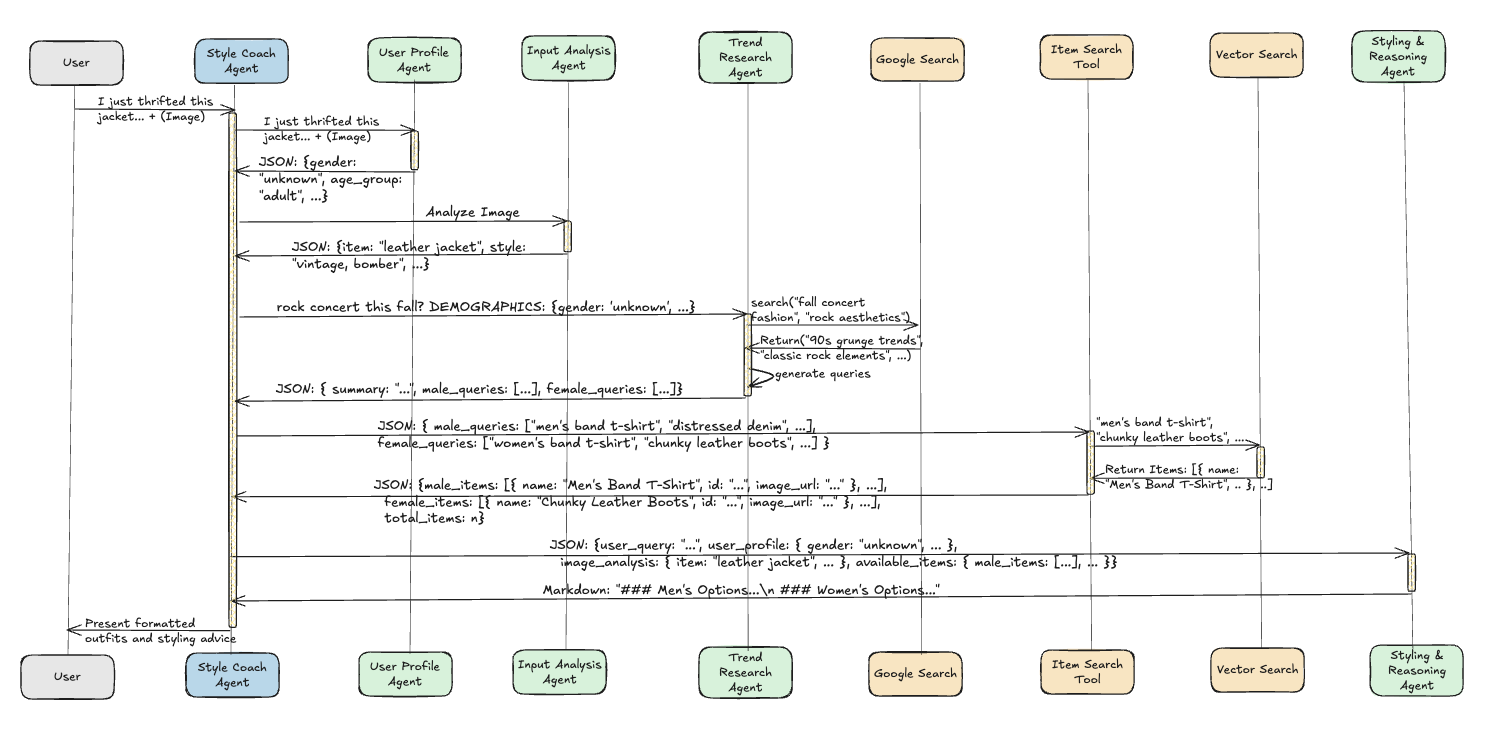

## 3. Environment Setup ⚙️
Before running the notebook, you need to configure the environment by installing the necessary libraries and providing access to your API keys and data.

### 1. Install Required Libraries
The core of this system is built on the Google Agent Development Kit (ADK).

In [ ]:
%pip install --upgrade google-adk

In [1]:
# Import necessary libraries
import os
import logging
import asyncio
import json
from typing import List
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import  InMemorySessionService
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools import google_search
from google.genai import types

# Ignore warnings from ADK and Gemini APIs
logging.getLogger("google.adk.runners").setLevel(logging.ERROR)
logging.getLogger("google_genai.types").setLevel(logging.ERROR)

### 2. Configure Google API Key
The system uses the Gemini API, which requires an API key. For security, store your key in Colab's secret manager under the name GOOGLE_API_KEY. The following code will then retrieve it and set it as an environment variable.

In [2]:
from google.colab import userdata

# Retrieve the secret key from Colab's secrets manager
my_api_key = userdata.get('GOOGLE_API_KEY')

# Set the environment variable using the retrieved secret
os.environ["GOOGLE_API_KEY"] = my_api_key


# Set environment variables required for running ADK (with Gemini API Key)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "False"



### 3. Mount Google Drive
To allow the notebook to access and analyze images, you need to mount your Google Drive. This gives the application a file path to read images from.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You can then display a test image to confirm that the connection is working correctly:

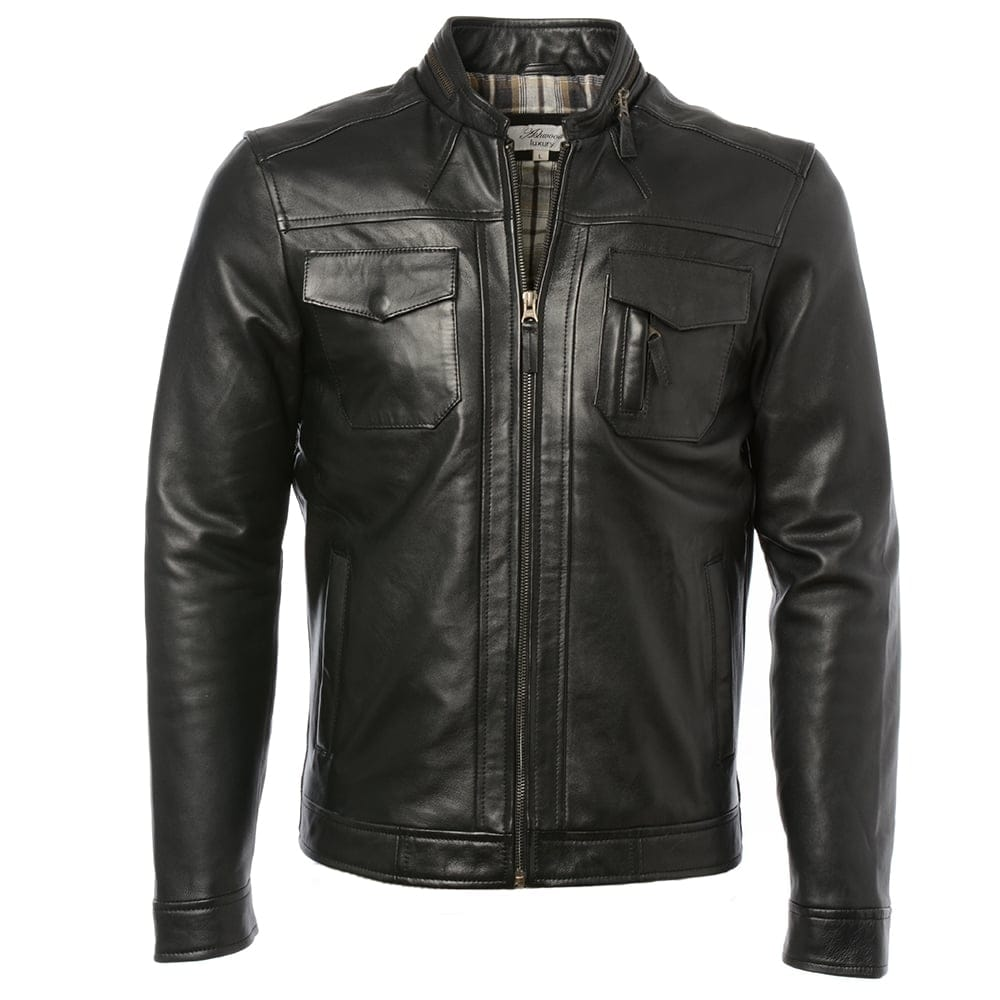

In [4]:
from IPython.display import Image, display

# Define the path to your image in Google Drive
image_path = '/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg'

# Display the image
try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")

## 4. Core Components & Implementation
This section details the implementation of the utility functions and the specialized agents that form the backbone of the Style Coach system.

### Low-Level Utility: The Vector Search Function
The system needs a way to query the product database. The call_vector_search function is a low-level utility that sends an HTTP request to a custom Vector Search REST API endpoint. It constructs a specific JSON payload with the query and search parameters and returns the retrieved items.

In [5]:
import requests
import json

def call_vector_search(url: str, query: str, rows: int = 3) -> dict | None:
    """
    Calls a custom Vector Search backend API for querying.

    Args:
        url: The URL of the search endpoint.
        query: The query string.
        rows: The number of result rows to return.

    Returns:
        A dictionary from the API's JSON response, or None on error.
    """
    headers = {'Content-Type': 'application/json'}
    # This payload is specific to the custom API endpoint in the tutorial.
    payload = {
        "query": query,
        "rows": rows,
        "dataset_id": "mercari3m_mm",  # Use Mercari 3M multimodal index
        "use_dense": True,  # Use multimodal search
        "use_sparse": True,  # Use keyword search too
        "rrf_alpha": 0.5,  # Both results are merged with the same weights
        "use_rerank": True, # Use Ranking API for reranking
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()  # Raise an exception for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling the search API: {e}")
        return None

### The Agent Definitions

Each agent is an instance of the `Agent` class from the ADK, configured with specific instructions, a Gemini model, and a set of tools.


  **1. `InputAnalysisAgent`**: A highly focused agent that uses the powerful `gemini-2.5-flash` multimodal model. Its sole purpose is to analyze an image and return a structured JSON description of the primary fashion item, including its type, style, and color. It has no external tools.


In [6]:
# Define the instructions for the image analysis agent.
analysis_instruction = f'''
You are a specialist AI model that analyzes images of fashion items. Your
only job is to identify the primary item in an image and return a
structured JSON object describing it.

- Your output MUST be only a single, valid JSON object.
- Do not add any conversational text or preambles.

The JSON object should contain the following keys:
- "item": The type of item (e.g., "leather jacket", "silver necklace", "ankle boots").
- "style": Descriptive keywords (e.g., "vintage", "minimalist", "chunky").
- "color": The primary color of the item.

Example Output:
{{
    "item": "leather jacket",
    "style": "vintage, bomber",
    "color": "dark brown"
}}
'''

# Create the agent instance. It has no tools.
input_analysis_agent = Agent(
    model='gemini-2.5-flash',
    name='InputAnalysisAgent',
    description=(
        'Analyzes an image of a clothing item and returns a structured JSON'
        ' description of its type, style, and color.'
    ),
    instruction=analysis_instruction,
    tools=[] # This agent is a specialist and needs no external tools.
)

print("✅ InputAnalysisAgent has been defined.")

✅ InputAnalysisAgent has been defined.


**2. `MercariSearchAgent`** (as `item_search_tool`): This is the dedicated database search agent, implemented as a tool function rather than an `Agent` instance. It receives the JSON output from the `TrendResearchAgent`, executes the queries using the `call_vector_search` utility, and formats the results for the final styling step.

In [7]:
SEARCH_API_URL = "https://www.ac0.cloudadvocacyorg.joonix.net/api/query"

def item_search_tool(queries: str) -> str:
    """
    Finds fashion items using vector search infrastructure and categorizes them by gender.

    This function processes fashion item queries in multiple formats and returns
    categorized search results. It supports both unisex queries and gender-specific
    searches, formatting results with appropriate gender tags and image URLs.

    Args:
        queries (str): JSON string containing search queries in one of these formats:
            - List of strings: ["query1", "query2"] for unisex searches
            - Dict with gender separation: {"male_queries": [...], "female_queries": [...]}
            - Dict with single queries: {"queries": [...]} for targeted searches
            - Plain string: single query string (fallback)

    Returns:
        str: JSON string containing search results with the following structure:
            {
                "items": [...],           # All found items (original format)
                "male_items": [...],      # Items tagged for male/unisex/targeted
                "female_items": [...],    # Items tagged for female
                "total_items": int        # Total count of items found
            }

    Example:
        >>> queries = '["men's shirts", "women's dresses"]'
        >>> result = item_search_tool(queries)
        >>> # Returns JSON with categorized fashion items

    Note:
        - Uses external call_vector_search function for actual searching
        - Each query retrieves up to 3 items (rows=3)
        - Image URLs are preserved with full parameters (?w=200&h=200&fitcrop&sharpen)
    """
    import json

    def format_item_for_styling(item, gender_tag):
        """Maps img_url to image_url and adds gender_tag."""
        formatted_item = dict(item)
        formatted_item["gender_tag"] = gender_tag

        if "img_url" in formatted_item:
            # Don't truncate - keep the full URL with ?w=200&h=200&fitcrop&sharpen
            formatted_item["image_url"] = formatted_item["img_url"]

        return formatted_item

    try:
        query_data = json.loads(queries)
    except json.JSONDecodeError:
        query_data = [queries]

    all_items = []
    male_items = []
    female_items = []

    if isinstance(query_data, list):
        print(f"Processing {len(query_data)} unisex queries")
        for query in query_data:
            result = call_vector_search(url=SEARCH_API_URL, query=query, rows=3)
            if result and "items" in result:
                formatted_items = [format_item_for_styling(item, "unisex") for item in result["items"]]
                all_items.extend(result["items"])
                male_items.extend(formatted_items)

    elif isinstance(query_data, dict):
        if "male_queries" in query_data and "female_queries" in query_data:
            print(f"Processing gender-separated queries")

            for query in query_data.get('male_queries', []):
                result = call_vector_search(url=SEARCH_API_URL, query=query, rows=3)
                if result and "items" in result:
                    formatted_items = [format_item_for_styling(item, "male") for item in result["items"]]
                    all_items.extend(result["items"])
                    male_items.extend(formatted_items)

            for query in query_data.get('female_queries', []):
                result = call_vector_search(url=SEARCH_API_URL, query=query, rows=3)
                if result and "items" in result:
                    formatted_items = [format_item_for_styling(item, "female") for item in result["items"]]
                    all_items.extend(result["items"])
                    female_items.extend(formatted_items)

        elif "queries" in query_data:
            print(f"Processing single-gender queries")
            for query in query_data['queries']:
                result = call_vector_search(url=SEARCH_API_URL, query=query, rows=3)
                if result and "items" in result:
                    formatted_items = [format_item_for_styling(item, "targeted") for item in result["items"]]
                    all_items.extend(result["items"])
                    male_items.extend(formatted_items)

    # FIX: Correct item counts
    print(f"Found: {len(all_items)} items total")
    print(f"Male-targeted items: {len(male_items)}")
    print(f"Female-targeted items: {len(female_items)}")

    enhanced_result = {
        "items": all_items,
        "male_items": male_items,
        "female_items": female_items,
        "total_items": len(all_items)
    }

    return json.dumps(enhanced_result)

**3. `UserProfileAgent`**: This agent specializes in demographic analysis. It analyzes the user's query and image to determine the likely age group ("adult" or "child") and gender ("male," "female," or "unknown"). It returns this information in a structured JSON format, including a confidence level and the evidence for its conclusion.


In [18]:
profile_instruction = '''
You are a demographic analysis specialist. Your job is to analyze user queries
and images to determine the user's age group and gender for fashion recommendations.

**Analysis Rules:**

**Age Group Detection:**
- Look for keywords: "kid", "child", "teen", "teenager", "boy", "girl", school age indicators
- If unclear, default to "adult"
- Age groups: "adult" or "child"

**Gender Detection:**
- Query indicators: "men's", "women's", "his", "her", "boyfriend", "girlfriend", "husband", "wife", gendered events
- Image indicators: If image shows a person, analyze clothing style and traditional gender markers
- Pronouns: "I" (check context clues), "he/him" (male), "she/her" (female)
- If unclear, mark as "unknown"
- Gender options: "male", "female", or "unknown"

**Confidence Levels:**
- "high": Clear explicit indicators ("women's jacket", obvious gendered terms)
- "medium": Context clues or image analysis
- "low": Weak signals or assumptions

**Output Format:**
Return ONLY a valid JSON object with this exact structure:
{
    "age_group": "adult",
    "gender": "male|female|unknown",
    "confidence": "high|medium|low",
    "evidence": "brief explanation of detection reasoning"
}
'''

user_profile_agent = Agent(
    model='gemini-2.5-flash',
    name='UserProfileAgent',
    description='Detects user demographics for fashion recommendations.',
    instruction=profile_instruction,
    tools=[]
)

**4. `TrendResearchAgent`**: This agent acts as a fashion market researcher. It takes the user's query and demographic profile, uses the `Google Search` tool to research the style, and generates a set of demographic-specific search queries. For an "unknown" gender, it intelligently creates separate query lists for both male and female fashion.

In [19]:
# This is the detailed and more effective instruction.
research_instruction = '''
You are a fashion market researcher. Your goal is to understand a user's style
query and produce a JSON object with demographic-specific search queries.

**Input Format:**
You will receive either:
1. Just a user query (for backward compatibility)
2. User query + demographic info in format: "ORIGINAL_QUERY DEMOGRAPHICS: age_group='adult', gender='male', confidence='high'"

**Query Generation Rules:**

**For Known Gender (male or female):**
- Generate 5 specific search queries for that gender only
- Use gender-specific terminology ("men's leather jacket", "women's midi dress")

**For Unknown Gender:**
- Generate 5 male-specific queries + 5 female-specific queries (10 total)
- Clearly separate them in the response

**For Child Age Group:**
- Use age-appropriate terminology ("kids", "youth", "teen")
- Focus on appropriate styles and fits

**Query Completeness Rules:**
- Your generated query list **must** be comprehensive enough for another agent to build a **complete, head-to-toe outfit**.
- If the user's query focuses on one item (e.g., an accessory), your job is to generate queries for the **other complementary categories** (tops, bottoms, footwear, etc.).
- For a **women's style request**, you must generate queries for at least one top, one bottom, one pair of footwear, and one relevant accessory.
- For a **men's style request**, you must generate queries for at least one top, one bottom, and one pair of footwear.

**Output Format:**
Your output MUST be a single, valid JSON object with this structure:

**For Known Gender:**
{
    "summary": "One or two-sentence summary of the style for the specific gender",
    "queries": [
        "gender-specific query 1",
        "gender-specific query 2",
        "gender-specific query 3",
        "gender-specific query 4",
        "gender-specific query 5"
    ]
}

**For Unknown Gender:**
{
    "summary": "One or two-sentence summary of the style (gender-neutral)",
    "male_queries": [
        "men's specific query 1",
        "men's specific query 2",
        "men's specific query 3",
        "men's specific query 4",
        "men's specific query 5"
    ],
    "female_queries": [
        "women's specific query 1",
        "women's specific query 2",
        "women's specific query 3",
        "women's specific query 4",
        "women's specific query 5"
    ]
}
'''

# We use the detailed instruction in the final agent definition.
trend_research_agent = Agent(
    model='gemini-1.5-flash',
    name='TrendResearchAgent',
    description='Researches fashion trends with demographic-specific queries.',
    instruction=research_instruction,
    tools=[google_search]
)

print("✅ TrendResearchAgent has been defined with the detailed instructions.")


✅ TrendResearchAgent has been defined with the detailed instructions.


**5. `Styling & Reasoning Agent`**: The final creative expert. This agent receives a complete data package containing the user query, profile, image analysis, style context, and available items. It uses its advanced reasoning capabilities to assemble 2-3 complete outfits, writing positive and encouraging explanations for why each look works.

In [20]:
styling_instruction = '''
You are a supportive and encouraging fashion expert. Create complete outfits based on user demographics with positive, uplifting language.

**Input Format Expected:**
You will receive a JSON object with this structure:
{
    "user_query": "original user request",
    "user_profile": {
        "age_group": "adult|child",
        "gender": "male|female|unknown",
        "confidence": "high|medium|low",
        "evidence": "detection reasoning"
    },
    "image_analysis": {...} or null,
    "style_context": "trend research summary",
    "available_items": {
        "male_items": [array of male-targeted items],
        "female_items": [array of female-targeted items],
        "total_items": number
    }
}

**TONE AND LANGUAGE GUIDELINES:**
- Always use POSITIVE, ENCOURAGING, and SUPPORTIVE language
- NEVER suggest someone has "low confidence" or any negative traits
- NEVER be insulting, demeaning, or mean
- Focus on how the outfit ENHANCES the wearer's best qualities
- Use empowering language like "flattering," "confidence-boosting," "stylish," "versatile"
- Emphasize the positive aspects of comfort, elegance, and personal style

**Outfit Composition Rules:**
- You MUST assemble a complete, head-to-toe look for every outfit.
- If the user provides an item (e.g., a jacket), your task is to find the other pieces to complete the outfit.
- A complete women's outfit typically includes: a top (shirt/blouse), a bottom (jeans/skirt), footwear, and at least one accessory.
- A complete men's outfit typically includes: a top (shirt/t-shirt), a bottom (jeans/trousers), and footwear. Accessories should be gender-appropriate.

**Styling Strategy Based on Gender:**
- For Known Gender: Create 2-3 outfits using items from appropriate gender array only
- For Unknown Gender: Create 2 men's outfits using male_items AND 2 women's outfits using female_items
- Clearly separate sections: "## Men's Options" and "## Women's Options"

**Required Structure for Each Outfit:**
- **Outfit Name**: Descriptive title
- **Item Details**: **Name** (ID: item_id): Description
- **Image**: [image_url] (MANDATORY for each item)
- **Why this look works**: Detailed, POSITIVE styling explanation (MANDATORY)

**CRITICAL Requirements:**
1. For every item, include image_url in format: **Image**: [actual_image_url_here]
2. For every outfit, include detailed "Why this look works" explanation
3. Use only items from the provided data - do not make up items or URLs
4. Always be encouraging, supportive, and positive
5. Avoid Redundancy: If the user provides an item (from image_analysis), you MUST NOT include another item of the same category (e.g., another jacket, another pair of earrings) in your recommended outfits. Focus only on complementary pieces.
6. Recommend Only New Items: Assume the user already owns the item they provided. Your recommended outfits should **only list the new, complementary items** needed to complete the look; do not repeat the user's original item in your output.

**Example Format:**
### Classic Look
**• Leather Jacket** (ID: m123): Perfect statement piece
**Image**: [https://u-mercari-images.mercdn.net/photos/m123_1.jpg?w=200&h=200&fitcrop&sharpen]

**Why this look works**: This combination creates a beautifully balanced silhouette by pairing the structured leather jacket with relaxed denim. The contrast between edgy and casual elements makes it incredibly versatile for multiple occasions while maintaining visual interest through texture variation. This look radiates confident, effortless style.

'''

styling_reasoning_agent = Agent(
    model='gemini-2.5-flash',
    name='StylingReasoningAgent',
    description='Creates gender-appropriate outfits with detailed, positive explanations from available items.',
    instruction=styling_instruction,
    tools=[]
)


## 5\. Orchestration and Execution 🚀

With all the specialist agents and tools defined, the **`StyleCoachAgent`** acts as the orchestrator, managing the entire workflow from user input to final output.

### The Main Agent: `StyleCoachAgent`

This is the "manager" agent that coordinates the others. Its instructions contain a strict, step-by-step workflow it must follow:

1.  **Call `UserProfileAgent`** to determine demographics.
2.  If an image is present, **call `InputAnalysisAgent`**.
3.  **Call `TrendResearchAgent`** to get context and search terms.
4.  **Call `updated_item_search_tool`** with the research results to find items.
5.  **Call `StylingReasoningAgent`** with all collected data to generate the final outfits.
6.  **Present the results** to the user.

This agent is initialized with the `AgentTool` wrapper for each of the other agents, allowing it to call them as tools during its reasoning process.



In [21]:
# This is the detailed and logically correct instruction for the main agent.
main_instruction = '''
You are a style coach coordinator. Follow this exact workflow:

**Step 1 - User Profile Analysis:**
Always call UserProfileAgent first with the user query and any image.

**Step 2 - Image Analysis (if image provided):**
If user provides an image, call InputAnalysisAgent.

**Step 3 - Request Classification:**
- Direct requests: "find black boots", image-only uploads
- Style requests: "cottagecore", "rock concert", "formal dinner"

**Step 4 - Research (for style requests only):**
For style requests, you MUST construct a new query string to send to the
TrendResearchAgent. This string MUST combine the original user query with
the demographic results from the UserProfileAgent (Step 1).
The exact format MUST be:
"ORIGINAL_QUERY DEMOGRAPHICS: age_group='VALUE', gender='VALUE', confidence='VALUE'"

**Step 5 - Item Search:**
Call item_search_tool with appropriate queries generated from the previous steps.
CRITICAL: When calling item_search_tool, pass the exact JSON from TrendResearchAgent as a string.
Never ask the user for gender - always use UserProfileAgent to detect it automatically.
If gender is "unknown", both male and female items should be found and presented.

**Step 6 - Final Styling:**
Call StylingReasoningAgent with this exact JSON format:
{
    "user_query": "original request",
    "user_profile": {"age_group": "VALUE", "gender": "VALUE", "confidence": "VALUE", "evidence": "VALUE"},
    "image_analysis": null_or_analysis_object,
    "style_context": "research_summary_or_your_context",
    "available_items": {"male_items": [], "female_items": [], "total_items": 0}
}

**Step 7 - Present Results:**
Present the styling results naturally to the user.

**Rules:**
- Call each agent only once per request
- Use exact formats specified above
- Handle both known and unknown gender scenarios
'''

# We use the detailed instruction in the final agent definition.
style_coach_agent = Agent(
    model='gemini-2.5-flash',
    name='StyleCoachAgent',
    description='Coordinates demographic-appropriate fashion styling.',
    instruction=main_instruction,
    tools=[
        item_search_tool,
        AgentTool(agent=trend_research_agent),
        AgentTool(agent=input_analysis_agent),
        AgentTool(agent=user_profile_agent),
        AgentTool(agent=styling_reasoning_agent)
    ]
)

print("✅ StyleCoachAgent has been defined with the detailed and correct workflow.")


✅ StyleCoachAgent has been defined with the detailed and correct workflow.


### The Reporting Function: `generate_styling_report`

This is a crucial helper function that takes the raw text output from the final agent and formats it into the clean, readable "🎨 PERSONAL STYLING REPORT". Its responsibilities include:

  * Parsing the user profile analysis and presenting it clearly.
  * Structuring the outfit recommendations with proper markdown headers.
  * Formatting item lists and adding clickable links for product images.
  * Adding a timestamped footer to the report for context.

In [22]:
import pathlib
import datetime as dt
import json


def generate_styling_report(log_display, user_profile_result, final_response_text):
    """
    Generates and prints a comprehensive, formatted styling report to the console.

    This function creates a professional styling report that includes the user's original
    request, profile analysis, styling recommendations, and system metadata. It handles
    JSON parsing for profile data and applies advanced text formatting to create a
    readable, well-structured output.

    Args:
        log_display (str): The original user query or request that initiated the styling
                          session. This will be displayed in the "Your Request" section.

        user_profile_result (str): JSON string or text containing the user's demographic
                                 profile analysis. Expected to contain fields like:
                                 - age_group: Target age demographic
                                 - gender: Gender classification
                                 - confidence: Confidence level of the analysis
                                 - evidence: Reasoning behind the classification
                                 Can also be plain text if JSON parsing fails.

        final_response_text (str): The complete styling recommendations text containing
                                 outfit suggestions, item details, and styling rationale.
                                 Expected to include markdown-formatted sections with
                                 headers, item names, image URLs, and explanations.

    Returns:
        None: This function only prints output to console and does not return values.

    Features:
        - Parses JSON profile data with fallback to plain text display
        - Formats markdown headers and sections for better readability
        - Extracts and formats product image URLs as clickable links
        - Handles item names and IDs with proper formatting
        - Adds visual separators and emoji icons for enhanced presentation
        - Includes timestamp and system information in report footer
        - Robust error handling for malformed JSON data

    Output Structure:
        1. Report header with title and decorative borders
        2. User's original request (formatted as bold text)
        3. Profile Analysis section (parsed from JSON or plain text)
        4. Styling Recommendations (formatted with headers, items, and links)
        5. Report Details footer (timestamp, system info, status)

    Example Usage:
        >>> user_query = "I need a casual outfit for weekend brunch"
        >>> profile = '{"age_group": "young_adult", "gender": "female", "confidence": "high"}'
        >>> recommendations = "## Casual Brunch Look\n### Outfit 1\n***Top*** (ID: 123)"
        >>> generate_styling_report(user_query, profile, recommendations)
        # Prints formatted report to console

    Note:
        - All output is printed directly to console using print() statements
        - JSON parsing includes handling for markdown code block wrappers (```
        - Image URLs are automatically converted to clickable markdown links
        - Function includes extensive text processing for optimal formatting
    """

    print("\n" + "="*75)
    print("🎨 PERSONAL STYLING REPORT")
    print("="*75)
    print()

    print("## 📝 Your Request")
    print(f"**{log_display.strip()}**")
    print()

    # FIX 1: Better formatted profile analysis (no JSON shown to user)
    if user_profile_result:
        print("## 🎯 Profile Analysis")
        print("*Based on your query, the system determined the following. Update your query if you need different demographic targeting:*")
        print()
        try:
            # Parse JSON and format nicely for user
            profile_text = user_profile_result.strip()
            if profile_text.startswith('```json'):
                # Remove markdown JSON wrapper
                profile_text = profile_text.replace('```json', '').replace('```', '').strip()

            if profile_text.startswith('{'):
                profile_data = json.loads(profile_text)
                print(f"**Age Group:** {profile_data.get('age_group', 'Not specified').title()}")
                print(f"**Gender:** {profile_data.get('gender', 'Not specified').title()}")
                print(f"**Confidence:** {profile_data.get('confidence', 'Not specified').title()}")
                print(f"**Reasoning:** {profile_data.get('evidence', 'Not specified')}")
            else:
                # Fallback for non-JSON responses
                print(f"**Analysis:** {profile_text}")
        except Exception as e:
            # Fallback if JSON parsing fails
            clean_text = user_profile_result.replace('```json', '').replace('```', '').strip()
            print(f"**Analysis:** {clean_text}")
        print()

    print("## ✨ Styling Recommendations")
    print()

    if final_response_text:
        lines = final_response_text.split('\n')
        formatted_lines = []

        for i, line in enumerate(lines):
            stripped_line = line.strip()
            if not stripped_line:
                continue

            # Main section headers
            if stripped_line.startswith('## '):
                if formatted_lines:
                    formatted_lines.append("")
                    formatted_lines.append("---")
                    formatted_lines.append("")
                formatted_lines.append(f"### {stripped_line[3:]}")
                formatted_lines.append("")
                continue

            # Outfit headers
            elif stripped_line.startswith('### '):
                formatted_lines.append("")
                formatted_lines.append(f"#### {stripped_line[4:]}")
                formatted_lines.append("")
                continue

            # Item names
            elif stripped_line.startswith('***') and '**' in stripped_line:
                if '(ID:' in stripped_line:
                    item_part = stripped_line.split('(ID:')[0].strip()
                    id_part = '(ID:' + stripped_line.split('(ID:')[1]
                    item_name = item_part.replace('***', '').replace('**', '').strip()
                    formatted_lines.append(f"**• {item_name}** {id_part}")
                else:
                    item_name = stripped_line.replace('***', '').replace('**', '').strip()
                    formatted_lines.append(f"**• {item_name}**")
                continue

            # Image URLs
            elif '**Image**: [' in stripped_line or 'Image**: ' in stripped_line:
                start_idx = stripped_line.find('https://')
                if start_idx > -1:
                    # Extract URL (everything from https:// to end of line or space)
                    url_part = stripped_line[start_idx:].strip()
                    formatted_lines.append(f"  📸 [View Product Image]({url_part})")
                formatted_lines.append("")
                continue

            # FIX 2: Add spacing before "Why this look works"
            elif 'Why this works' in stripped_line or 'Styling Rationale' in stripped_line:
                formatted_lines.append("")  # Extra space before the explanation
                formatted_lines.append("**💡 Why this look works:**")
                continue

            # Regular text
            else:
                if stripped_line.startswith('(ID:') or any(word in stripped_line.lower() for word in ['comfortable', 'perfect', 'trendy', 'featuring']):
                    formatted_lines.append(f"  *{stripped_line}*")
                else:
                    clean_line = stripped_line.replace('***', '**')
                    formatted_lines.append(clean_line)

        formatted_response = '\n'.join(formatted_lines)
        print(formatted_response)
    else:
        print("*No styling recommendations were generated.*")

    print()
    print("---")
    print()
    print("## 📊 Report Details")
    current_time = dt.datetime.now()
    print(f"**Generated:** {current_time.strftime('%B %d, %Y at %I:%M %p')}")
    print(f"**System:** Multi-Agent Gender-Aware Style Coach")
    print(f"**Status:** ✅ Complete")
    print()
    print("="*75)

### The Execution Wrapper: `test_gender_aware_system`

To simplify running a complete test, the **`test_gender_aware_system`** asynchronous function handles the entire process. It takes a user's text query and/or an image path, sets up the necessary session, runs the main `StyleCoachAgent`, and then passes the final results to the reporting function for formatting.

In [23]:
async def test_gender_aware_system(
    query: str | None = None,
    image_path: str | None = None,
):
    """
    Tests and executes the complete gender-aware styling system with multimodal input support.

    This async function orchestrates the entire styling recommendation pipeline, including
    user profile analysis and personalized styling suggestions. It supports both text queries
    and image inputs, processes them through specialized AI agents, and generates a
    comprehensive styling report.

    Args:
        query (str | None, optional): Text-based styling query from the user.
            Examples: "I need a casual outfit for work", "What should I wear to a wedding?"
            Defaults to None.

        image_path (str | None, optional): Path to an image file for visual styling analysis.
            Must be a valid file path to a JPEG image. Used for outfit analysis or style inspiration.
            Defaults to None.

    Returns:
        None: This function prints results to console and does not return values.
              Early returns on error conditions (missing inputs, file not found).

    Raises:
        FileNotFoundError: Implicitly when image_path points to non-existent file.
        Various exceptions: From async session operations or agent processing.

    Workflow:
        1. Input Validation: Ensures at least one input (query or image) is provided
        2. Content Preparation: Builds multipart message with text and/or image data
        3. Profile Analysis: Runs user profile agent to determine demographics
        4. Styling Analysis: Executes main style coach agent for recommendations
        5. Report Generation: Formats and displays comprehensive styling report

    Technical Details:
        - Creates separate sessions for profile analysis and main styling
        - Uses InMemorySessionService for session management
        - Processes async events from Runner instances
        - Supports JPEG image format with automatic MIME type detection
        - Handles concurrent agent execution with proper async patterns

    Dependencies:
        - session_service: InMemorySessionService instance
        - user_profile_agent: AI agent for demographic analysis
        - style_coach_agent: AI agent for styling recommendations
        - generate_styling_report: Function for formatted output generation

    Example Usage:
        # Text-only query
        >>> await test_gender_aware_system(query="I need summer business attire")

        # Image-only analysis
        >>> await test_gender_aware_system(image_path="./outfit.jpg")

        # Combined text and image
        >>> await test_gender_aware_system(
        ...     query="Is this outfit appropriate for a date?",
        ...     image_path="./my_outfit.jpg"
        ... )

    Error Conditions:
        - Returns early if both query and image_path are None
        - Returns early if specified image file does not exist
        - Handles agent processing errors gracefully through async event system

    Note:
        - Function uses hardcoded APP_NAME and USER_ID for testing purposes
        - Image processing assumes JPEG format but could be extended
        - All output is directed to console via generate_styling_report function
        - Session IDs are automatically managed by the session service
    """

    session_service = InMemorySessionService()
    APP_NAME = "style_coach_app"
    USER_ID = "user123"

    if not query and not image_path:
        print("Error: Please provide a text query or an image path.")
        return

    # Build a list of parts for the user's message
    parts = []
    log_display = ""
    if query:
        parts.append(types.Part(text=query))
        log_display += f"Query: '{query}'"
    if image_path:
        img = pathlib.Path(image_path)
        if not img.exists():
            print(f"Error: Image file not found at {image_path}")
            return

        image_part = types.Part(
            inline_data=types.Blob(
                mime_type="image/jpeg",
                data=img.read_bytes(),
            )
        )
        parts.append(image_part)
        log_display += f" | Image: '{image_path}'"

    print(f"\n>>> User Input: {log_display.strip()}")

    # Get user profile analysis
    profile_session = await session_service.create_session(app_name=APP_NAME, user_id=USER_ID + "_profile")
    profile_runner = Runner(app_name=APP_NAME, agent=user_profile_agent, session_service=session_service)
    profile_content = types.Content(role="user", parts=parts)

    user_profile_result = None
    async for event in profile_runner.run_async(user_id=USER_ID + "_profile", session_id=profile_session.id, new_message=profile_content):
        if event.is_final_response():
            if event.content and event.content.parts:
                user_profile_result = event.content.parts[0].text
            break

    # Main styling session
    session = await session_service.create_session(app_name=APP_NAME, user_id=USER_ID)
    runner = Runner(app_name=APP_NAME, agent=style_coach_agent, session_service=session_service)
    content = types.Content(role="user", parts=parts)

    final_response_text = None
    async for event in runner.run_async(user_id=USER_ID, session_id=session.id, new_message=content):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break

    # Generate the formatted report using the separate function
    generate_styling_report(log_display, user_profile_result, final_response_text)



In [16]:
await test_gender_aware_system(query="What should I wear with this jacket for a 90s concert?",
                               image_path='/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg')


>>> User Input: Query: 'What should I wear with this jacket for a 90s concert?' | Image: '/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg'


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12eef140>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d148f05f0>, 6035.818963124)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d1492c4d0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d124b0140>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d12e60170>, 6041.135838079)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d124b0080>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e728a0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d12e03530>, 6042.021916318)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d12e727e0>
ERROR:asyncio:Unclosed client session
cl

Processing gender-separated queries


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e40410>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d14a57e90>, 6052.828738681)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d12e404a0>


Found: 28 items total
Male-targeted items: 15
Female-targeted items: 13


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e72ae0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d12e02210>, 6219.407899647)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d12e72870>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e0f8f0>



🎨 PERSONAL STYLING REPORT

## 📝 Your Request
**Query: 'What should I wear with this jacket for a 90s concert?' | Image: '/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg'**

## 🎯 Profile Analysis
*Based on your query, the system determined the following. Update your query if you need different demographic targeting:*

**Age Group:** Adult
**Gender:** Male
**Confidence:** High
**Reasoning:** The jacket displayed is a men's style leather jacket. The query refers to a '90s concert' which is typically attended by adults.

## ✨ Styling Recommendations

You've got a fantastic starting point with your black leather jacket for a 90s concert – it's such a versatile and iconic piece that instantly brings a cool, edgy vibe! Let's build some amazing, confidence-boosting outfits around it to ensure you look and feel incredible for the event.
Since your gender is unknown, I've put together some fantastic options for both men and women, channeling different facets of that incredible 90s 

In [14]:
await test_gender_aware_system(query="What should I wear for Taylor Swift concert?")


>>> User Input: Query: 'What should I wear for Taylor Swift concert?'


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a80b70e0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x78d6a59486b0>, 230.793173868)])']
connector: <aiohttp.connector.TCPConnector object at 0x78d6a7e86030>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a7e9f890>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x78d6a59493d0>, 236.086966725)])']
connector: <aiohttp.connector.TCPConnector object at 0x78d6a7e9f7d0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a7ca3080>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x78d6a5948710>, 233.352519171)])']
connector: <aiohttp.connector.TCPConnector object at 0x78d6a7ca25a0>
ERROR:asyncio:Unclosed client session
clien

Processing gender-separated queries


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a7e9faa0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x78d6a59486b0>, 245.381733425)])']
connector: <aiohttp.connector.TCPConnector object at 0x78d6a7e9ee10>


Found: 30 items total
Male-targeted items: 15
Female-targeted items: 15


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a7b8b530>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x78d6a5949310>, 437.874962228)])']
connector: <aiohttp.connector.TCPConnector object at 0x78d6a7b88380>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78d6a7e9fdd0>



🎨 PERSONAL STYLING REPORT

## 📝 Your Request
**Query: 'What should I wear for Taylor Swift concert?'**

## 🎯 Profile Analysis
*Based on your query, the system determined the following. Update your query if you need different demographic targeting:*

**Age Group:** Adult
**Gender:** Unknown
**Confidence:** Medium
**Reasoning:** Query uses 'I' and lacks age/gender-specific keywords or an image. Defaulting to adult based on no child indicators.

## ✨ Styling Recommendations

  *It's absolutely wonderful that you're getting ready for a Taylor Swift concert! This is the perfect occasion to express your personal style and embrace the fun, celebratory atmosphere. Whether you love a bit of sparkle, a nod to a specific era, or simply comfortable and stylish fan gear, we've got some fantastic ideas to help you shine.*
Since your gender wasn't specified, we've put together some fabulous options for both men and women, ensuring everyone can find a look that makes them feel confident and ready to 

In [24]:
await test_gender_aware_system(query="What should I wear with these earings for a casual date night?",
                               image_path='/content/drive/My Drive/Colab Notebooks/images/test_img3.jpg')


>>> User Input: Query: 'What should I wear with these earings for a casual date night?' | Image: '/content/drive/My Drive/Colab Notebooks/images/test_img3.jpg'


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e405f0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d1484b650>, 7638.937305259)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d12e0fec0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d12e739b0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d1484b530>, 7656.37868644)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d12e72150>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d124b0950>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d12e947d0>, 7658.051436583)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d124b3560>
ERROR:asyncio:Unclosed client session
cli

Processing gender-separated queries


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d124b2ff0>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d147b67b0>, 7667.9629759)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d124b1460>


Found: 30 items total
Male-targeted items: 15
Female-targeted items: 15


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d14814200>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7e1d1484b770>, 7795.851392563)])']
connector: <aiohttp.connector.TCPConnector object at 0x7e1d14817290>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7e1d124b1e80>



🎨 PERSONAL STYLING REPORT

## 📝 Your Request
**Query: 'What should I wear with these earings for a casual date night?' | Image: '/content/drive/My Drive/Colab Notebooks/images/test_img3.jpg'**

## 🎯 Profile Analysis
*Based on your query, the system determined the following. Update your query if you need different demographic targeting:*

**Age Group:** Adult
**Gender:** Female
**Confidence:** Medium
**Reasoning:** The query mentions 'casual date night', which typically implies an adult user. The pink, pavé-set hoop earrings are a style commonly, though not exclusively, worn by women.

## ✨ Styling Recommendations

  *Here are some fabulous outfit ideas to perfectly complement your stylish pink hoop earrings for a casual date night! We've focused on creating looks that are both comfortable and chic, ensuring you feel amazing and confident.*

---

### Men's Options


#### 1. Effortless Cool

This look pairs classic denim with a smart button-down, creating a relaxed yet polished vibe tha

In [ ]:
await test_gender_aware_system(query="What should I wear with this jacket for men?",
                               image_path='/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg')